# Brain Tumor MRI Classification

This notebook demonstrates an end-to-end machine learning pipeline for classifying brain tumor MRI images using deep learning. Classes include glioma, meningioma, pituitary, and no tumor.

Dataset: Brain Tumor MRI (Kaggle)

In [1]:
# Import Required Libraries
import os
import sys
import json
import logging
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score, 
    precision_score, recall_score, roc_auc_score, roc_curve, auc
)
from sklearn.utils.class_weight import compute_class_weight

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Setup paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data'
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
MODELS_DIR = PROJECT_ROOT / 'models'
LOGS_DIR = PROJECT_ROOT / 'logs'

# Create directories
MODELS_DIR.mkdir(exist_ok=True)
LOGS_DIR.mkdir(exist_ok=True)

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Configuration
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 1e-4

# Class labels for Brain Tumor MRI Classification
CLASS_LABELS = {
    'Glioma': 0,
    'Meningioma': 1,
    'Pituitary': 2,
    'No_Tumor': 3
}
CLASS_NAMES = list(CLASS_LABELS.keys())
NUM_CLASSES = len(CLASS_LABELS)

print(f"✓ Libraries loaded successfully")
print(f"✓ TensorFlow version: {tf.__version__}")
print(f"✓ GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

✓ Libraries loaded successfully
✓ TensorFlow version: 2.20.0
✓ GPU available: False


# Brain Tumor MRI Classification
## Transfer Learning with MobileNetV2

This notebook demonstrates an end-to-end machine learning pipeline for classifying brain tumors in MRI scans using deep learning. The dataset contains 4 tumor classes (Glioma, Meningioma, Pituitary, No Tumor), with ~7,400 labeled MRI images.

**Objective**: Build, train, evaluate, and deploy a classification model with comprehensive metrics and interpretability.

**Dataset**: Brain Tumor MRI Classification (Kaggle)
**Model**: MobileNetV2 (Transfer Learning)
**Framework**: TensorFlow/Keras

## 1. Load and Explore the Dataset

In [2]:
# Load images and organize by class
def load_images_from_directory(directory: Path, target_size=IMAGE_SIZE):
    """Load all images from directory organized by class subdirectories."""
    images = []
    labels = []
    image_paths = []
    
    for class_name in CLASS_NAMES:
        class_dir = directory / class_name
        if not class_dir.exists():
            print(f"Warning: Class directory not found: {class_dir}")
            continue
        
        image_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
        print(f"Loading {len(image_files)} images from class: {class_name}")
        
        for image_file in image_files:
            try:
                img = Image.open(image_file).convert('RGB')
                img = img.resize(target_size, Image.LANCZOS)
                img_array = np.array(img, dtype=np.float32) / 255.0
                
                images.append(img_array)
                labels.append(CLASS_LABELS[class_name])
                image_paths.append(str(image_file))
            except Exception as e:
                print(f"Error loading {image_file}: {e}")
                continue
    
    return np.array(images), np.array(labels), image_paths

# Load training and test data
print("Loading training data...")
X_train_full, y_train_full, train_paths = load_images_from_directory(TRAIN_DIR)

print(f"\n✓ Dataset loaded successfully!")
print(f"✓ Total images: {len(X_train_full)}")
print(f"✓ Images shape: {X_train_full.shape}")
print(f"✓ Labels shape: {y_train_full.shape}")

Loading training data...
Loading 1220 images from class: Glioma
Loading 1227 images from class: Meningioma
Loading 1294 images from class: Pituitary
Loading 1537 images from class: No_Tumor

✓ Dataset loaded successfully!
✓ Total images: 5278
✓ Images shape: (5278, 224, 224, 3)
✓ Labels shape: (5278,)


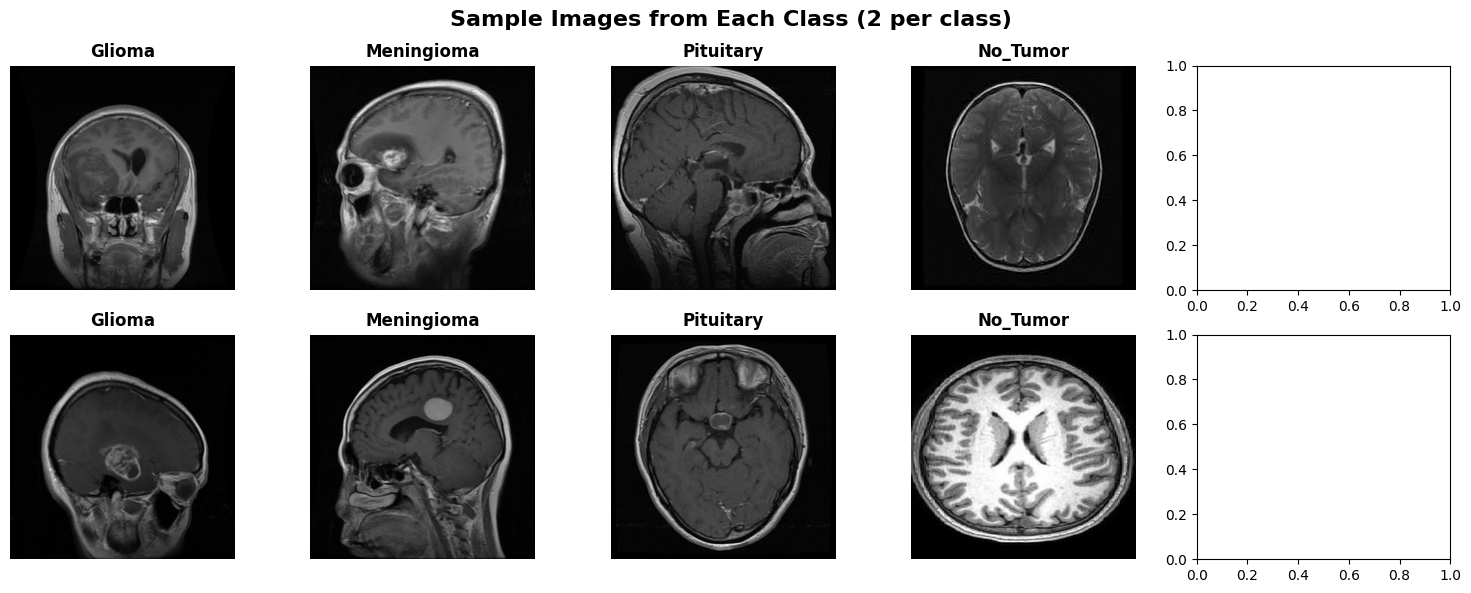

✓ Sample images displayed


In [3]:
# Display sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images from Each Class (2 per class)', fontsize=16, fontweight='bold')

for class_idx, class_name in enumerate(CLASS_NAMES):
    # Get two random images from this class
    class_indices = np.where(y_train_full == class_idx)[0]
    if len(class_indices) > 0:
        sample_indices = np.random.choice(class_indices, size=min(2, len(class_indices)), replace=False)
        
        for sample_num, img_idx in enumerate(sample_indices):
            ax = axes[sample_num, class_idx]
            ax.imshow(X_train_full[img_idx])
            ax.set_title(class_name, fontweight='bold')
            ax.axis('off')

plt.tight_layout()
plt.savefig(LOGS_DIR / 'sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Sample images displayed")

## 2. Data Preprocessing and Train/Val/Test Split

In [4]:
# Split data into train, validation, test
print("Creating train/validation/test split (70/15/15)...")

# First split: train+val vs test (85 vs 15)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_train_full, y_train_full,
    test_size=0.15,
    random_state=42,
    stratify=y_train_full
)

# Second split: train vs val (70 vs 15 of original)
val_ratio = 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_ratio,
    random_state=42,
    stratify=y_temp
)

print(f"✓ Training set:   {len(X_train)} images")
print(f"✓ Validation set: {len(X_val)} images")
print(f"✓ Test set:       {len(X_test)} images")

# One-hot encode labels
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

print(f"✓ Labels one-hot encoded")

Creating train/validation/test split (70/15/15)...
✓ Training set:   3694 images
✓ Validation set: 792 images
✓ Test set:       792 images
✓ Labels one-hot encoded


In [5]:
# Normalize with ImageNet statistics
print("Applying ImageNet normalization...")
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

def normalize_images(images, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    normalized = images.copy()
    for i in range(3):
        normalized[:, :, :, i] = (normalized[:, :, :, i] - mean[i]) / std[i]
    return normalized

X_train_norm = normalize_images(X_train)
X_val_norm = normalize_images(X_val)
X_test_norm = normalize_images(X_test)

print("✓ Normalization complete")

Applying ImageNet normalization...
✓ Normalization complete


## 3. Dataset Feature Visualizations & Statistics

VISUALIZATION 1: Class Distribution


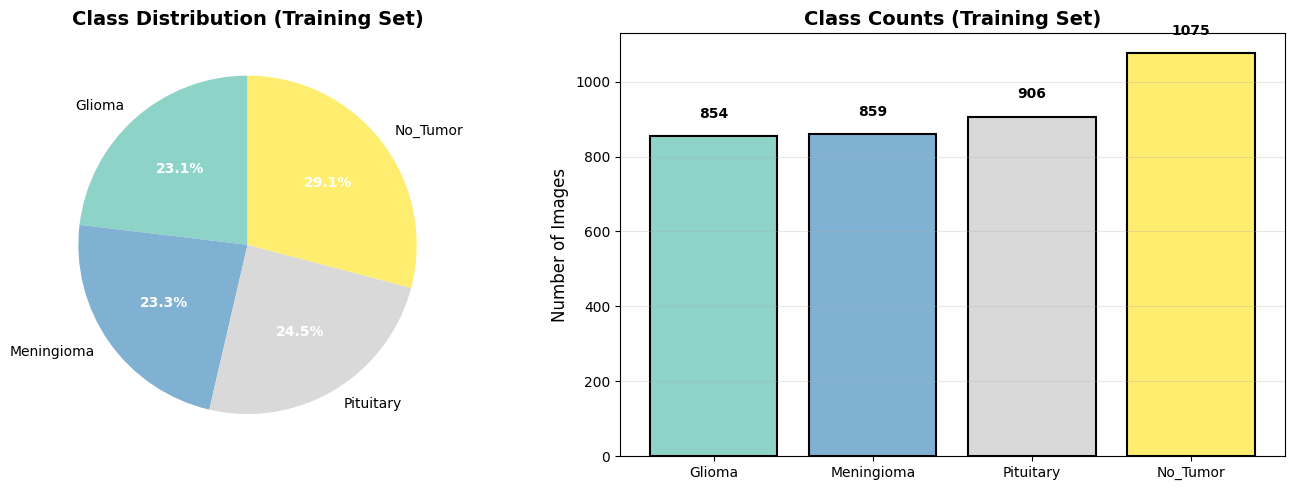

Class Distribution:
        Class  Count
0      Glioma    854
1  Meningioma    859
2   Pituitary    906
3    No_Tumor   1075



In [6]:
# VISUALIZATION 1: Class Distribution
print("VISUALIZATION 1: Class Distribution")
class_counts = pd.Series(y_train, index=[''] * len(y_train)).value_counts().sort_index()
class_labels_list = [CLASS_NAMES[i] for i in range(NUM_CLASSES)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = plt.cm.Set3(np.linspace(0, 1, NUM_CLASSES))
wedges, texts, autotexts = axes[0].pie(
    class_counts.values,
    labels=class_labels_list,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)
axes[0].set_title('Class Distribution (Training Set)', fontsize=14, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Bar chart
axes[1].bar(class_labels_list, class_counts.values, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Number of Images', fontsize=12)
axes[1].set_title('Class Counts (Training Set)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(class_counts.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(LOGS_DIR / 'visualization_1_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Class Distribution:\n{pd.DataFrame({'Class': class_labels_list, 'Count': class_counts.values})}")
print()

VISUALIZATION 2: Average Brightness per Class


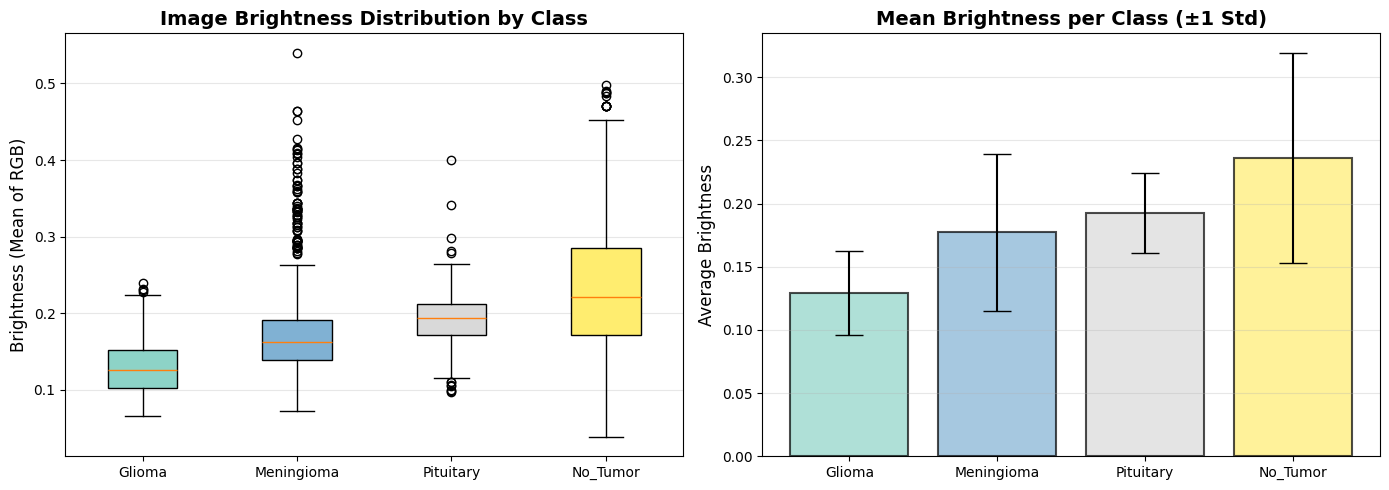

Average Brightness Statistics:
Glioma       - Mean: 0.129, Std: 0.033, Range: [0.066, 0.239]
Meningioma   - Mean: 0.177, Std: 0.062, Range: [0.073, 0.540]
Pituitary    - Mean: 0.193, Std: 0.032, Range: [0.097, 0.400]
No_Tumor     - Mean: 0.236, Std: 0.083, Range: [0.038, 0.498]



In [7]:
# VISUALIZATION 2: Average Brightness per Class
print("VISUALIZATION 2: Average Brightness per Class")

brightness_stats = []
for class_idx in range(NUM_CLASSES):
    class_images = X_train[y_train == class_idx]
    # Calculate brightness as average of RGB channels
    brightness = np.mean(class_images, axis=(1, 2, 3))
    brightness_stats.append({
        'class': CLASS_NAMES[class_idx],
        'mean': np.mean(brightness),
        'std': np.std(brightness),
        'min': np.min(brightness),
        'max': np.max(brightness),
        'values': brightness
    })

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
brightness_data = [stat['values'] for stat in brightness_stats]
bp = axes[0].boxplot(brightness_data, labels=CLASS_NAMES, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0].set_ylabel('Brightness (Mean of RGB)', fontsize=12)
axes[0].set_title('Image Brightness Distribution by Class', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Bar chart with error bars
means = [stat['mean'] for stat in brightness_stats]
stds = [stat['std'] for stat in brightness_stats]
axes[1].bar(CLASS_NAMES, means, yerr=stds, capsize=10, color=colors, edgecolor='black', linewidth=1.5, alpha=0.7)
axes[1].set_ylabel('Average Brightness', fontsize=12)
axes[1].set_title('Mean Brightness per Class (±1 Std)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(LOGS_DIR / 'visualization_2_brightness.png', dpi=150, bbox_inches='tight')
plt.show()

print("Average Brightness Statistics:")
for stat in brightness_stats:
    print(f"{stat['class']:12} - Mean: {stat['mean']:.3f}, Std: {stat['std']:.3f}, Range: [{stat['min']:.3f}, {stat['max']:.3f}]")
print()

VISUALIZATION 3: Image Resolution & Size Distribution


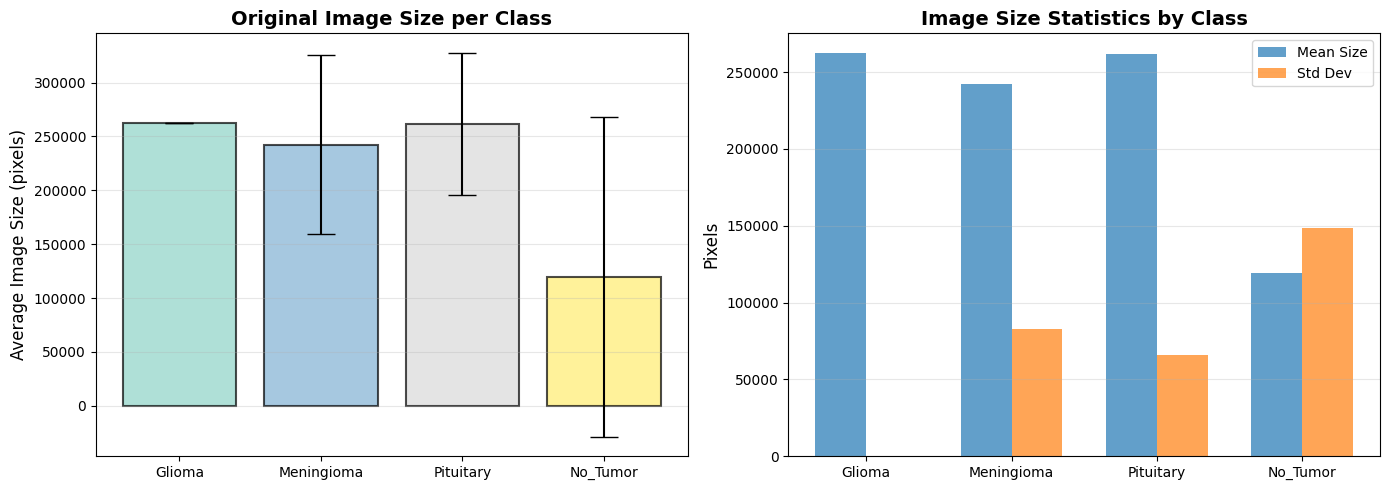

Image Resolution Statistics:
Glioma       - Mean: 262,144, Std: 0, Range: [262,144, 262,144]
Meningioma   - Mean: 242,331, Std: 82,822, Range: [39,240, 1,819,425]
Pituitary    - Mean: 261,847, Std: 66,026, Range: [40,804, 1,863,225]
No_Tumor     - Mean: 119,496, Std: 148,467, Range: [29,700, 2,073,600]



In [8]:
# VISUALIZATION 3: Image Resolution/Aspect Ratio Analysis
print("VISUALIZATION 3: Image Resolution & Size Distribution")

# Get original image dimensions before resizing
resolution_stats = []
for class_name in CLASS_NAMES:
    class_dir = TRAIN_DIR / class_name
    if class_dir.exists():
        sizes = []
        for img_file in list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png')):
            try:
                img = Image.open(img_file)
                sizes.append(img.size[0] * img.size[1])  # Total pixels
            except:
                pass
        resolution_stats.append({
            'class': class_name,
            'mean_pixels': np.mean(sizes) if sizes else 0,
            'std_pixels': np.std(sizes) if sizes else 0,
            'min_pixels': np.min(sizes) if sizes else 0,
            'max_pixels': np.max(sizes) if sizes else 0
        })

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
means_res = [stat['mean_pixels'] for stat in resolution_stats]
stds_res = [stat['std_pixels'] for stat in resolution_stats]
axes[0].bar(CLASS_NAMES, means_res, yerr=stds_res, capsize=10, color=colors, edgecolor='black', linewidth=1.5, alpha=0.7)
axes[0].set_ylabel('Average Image Size (pixels)', fontsize=12)
axes[0].set_title('Original Image Size per Class', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Normalized features per class
feature_matrix = np.array([[stat['mean_pixels'], stat['std_pixels']] for stat in resolution_stats])
feature_names = ['Mean Size', 'Std Dev']
x = np.arange(len(CLASS_NAMES))
width = 0.35

for i, feature_name in enumerate(feature_names):
    axes[1].bar(x + i*width, feature_matrix[:, i], width, label=feature_name, alpha=0.7)

axes[1].set_ylabel('Pixels', fontsize=12)
axes[1].set_title('Image Size Statistics by Class', fontsize=14, fontweight='bold')
axes[1].set_xticks(x + width / 2)
axes[1].set_xticklabels(CLASS_NAMES)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(LOGS_DIR / 'visualization_3_resolution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Image Resolution Statistics:")
for stat in resolution_stats:
    print(f"{stat['class']:12} - Mean: {stat['mean_pixels']:,.0f}, Std: {stat['std_pixels']:,.0f}, Range: [{stat['min_pixels']:,.0f}, {stat['max_pixels']:,.0f}]")
print()

## 4. Build the Transfer Learning Model

In [9]:
# Create Transfer Learning Model with MobileNetV2
print("Creating transfer learning model with MobileNetV2...")

# Load pre-trained MobileNetV2
base_model = MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Freeze most layers, unfreeze last 50
freeze_until = len(base_model.layers) - 50
for layer in base_model.layers[:freeze_until]:
    layer.trainable = False

print(f"✓ Base model layers: {len(base_model.layers)}")
print(f"✓ Frozen layers: {freeze_until}")
print(f"✓ Trainable layers: {len(base_model.layers) - freeze_until}")

# Build full model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("✓ Model compiled successfully")
print(f"\nModel Summary:")
model.summary()

Creating transfer learning model with MobileNetV2...
✓ Base model layers: 154
✓ Frozen layers: 104
✓ Trainable layers: 50
✓ Model compiled successfully

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,620,868 (10.00 MB)

 Trainable params: 2,217,220 (8.46 MB)

 Non-trainable params: 403,648 (1.54 MB)

## 5. Train the Model with Callbacks

In [10]:
# Calculate class weights for imbalanced data
print("Calculating class weights...")
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print(f"Class weights: {class_weight_dict}")

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=str(MODELS_DIR / 'brain_tumor_model_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Train model
print("\nTraining model...")
history = model.fit(
    X_train_norm, y_train_encoded,
    validation_data=(X_val_norm, y_val_encoded),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("✓ Training complete!")

Calculating class weights...
Class weights: {0: np.float64(1.0813817330210773), 1: np.float64(1.0750873108265424), 2: np.float64(1.0193156732891833), 3: np.float64(0.8590697674418605)}

Training model...
Epoch 1/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6279 - loss: 6.9611 - precision: 0.6692 - recall: 0.5632 
Epoch 1: val_accuracy improved from None to 0.75253, saving model to /Users/apple/MLOP/models/brain_tumor_model_best.h5


2025-11-21 21:29:35,648 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


116/116 ━━━━━━━━━━━━━━━━━━━━ 47s 350ms/step - accuracy: 0.7666 - loss: 6.5334 - precision: 0.8029 - recall: 0.7212 - val_accuracy: 0.7525 - val_loss: 6.4811 - val_precision: 0.8517 - val_recall: 0.6162 - learning_rate: 1.0000e-04
Epoch 2/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9124 - loss: 5.9702 - precision: 0.9221 - recall: 0.9006 
Epoch 2: val_accuracy improved from 0.75253 to 0.80556, saving model to /Users/apple/MLOP/models/brain_tumor_model_best.h5


2025-11-21 21:30:13,585 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 325ms/step - accuracy: 0.9226 - loss: 5.8757 - precision: 0.9305 - recall: 0.9099 - val_accuracy: 0.8056 - val_loss: 6.0689 - val_precision: 0.8417 - val_recall: 0.7449 - learning_rate: 1.0000e-04
Epoch 3/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9648 - loss: 5.5440 - precision: 0.9706 - recall: 0.9579 
Epoch 3: val_accuracy improved from 0.80556 to 0.81187, saving model to /Users/apple/MLOP/models/brain_tumor_model_best.h5


2025-11-21 21:30:49,252 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


116/116 ━━━━━━━━━━━━━━━━━━━━ 36s 307ms/step - accuracy: 0.9643 - loss: 5.4716 - precision: 0.9688 - recall: 0.9567 - val_accuracy: 0.8119 - val_loss: 5.6875 - val_precision: 0.8479 - val_recall: 0.7816 - learning_rate: 1.0000e-04
Epoch 4/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9697 - loss: 5.2052 - precision: 0.9720 - recall: 0.9657 
Epoch 4: val_accuracy improved from 0.81187 to 0.85985, saving model to /Users/apple/MLOP/models/brain_tumor_model_best.h5


2025-11-21 21:31:25,023 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


116/116 ━━━━━━━━━━━━━━━━━━━━ 36s 308ms/step - accuracy: 0.9737 - loss: 5.1150 - precision: 0.9768 - recall: 0.9702 - val_accuracy: 0.8598 - val_loss: 5.2532 - val_precision: 0.8865 - val_recall: 0.8384 - learning_rate: 1.0000e-04
Epoch 5/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9859 - loss: 4.8316 - precision: 0.9867 - recall: 0.9826 
Epoch 5: val_accuracy improved from 0.85985 to 0.86742, saving model to /Users/apple/MLOP/models/brain_tumor_model_best.h5


2025-11-21 21:31:59,528 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 297ms/step - accuracy: 0.9873 - loss: 4.7416 - precision: 0.9888 - recall: 0.9838 - val_accuracy: 0.8674 - val_loss: 4.9083 - val_precision: 0.8883 - val_recall: 0.8535 - learning_rate: 1.0000e-04
Epoch 6/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9900 - loss: 4.4706 - precision: 0.9904 - recall: 0.9883 
Epoch 6: val_accuracy improved from 0.86742 to 0.89394, saving model to /Users/apple/MLOP/models/brain_tumor_model_best.h5


2025-11-21 21:32:34,798 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


116/116 ━━━━━━━━━━━━━━━━━━━━ 35s 304ms/step - accuracy: 0.9903 - loss: 4.3832 - precision: 0.9910 - recall: 0.9889 - val_accuracy: 0.8939 - val_loss: 4.4770 - val_precision: 0.9006 - val_recall: 0.8813 - learning_rate: 1.0000e-04
Epoch 7/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9942 - loss: 4.1033 - precision: 0.9961 - recall: 0.9938 
Epoch 7: val_accuracy improved from 0.89394 to 0.92551, saving model to /Users/apple/MLOP/models/brain_tumor_model_best.h5


2025-11-21 21:33:10,232 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


116/116 ━━━━━━━━━━━━━━━━━━━━ 35s 306ms/step - accuracy: 0.9919 - loss: 4.0233 - precision: 0.9932 - recall: 0.9905 - val_accuracy: 0.9255 - val_loss: 4.0679 - val_precision: 0.9321 - val_recall: 0.9179 - learning_rate: 1.0000e-04
Epoch 8/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9913 - loss: 3.7570 - precision: 0.9922 - recall: 0.9911 
Epoch 8: val_accuracy improved from 0.92551 to 0.93182, saving model to /Users/apple/MLOP/models/brain_tumor_model_best.h5


2025-11-21 21:33:47,457 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


116/116 ━━━━━━━━━━━━━━━━━━━━ 37s 321ms/step - accuracy: 0.9913 - loss: 3.6730 - precision: 0.9924 - recall: 0.9911 - val_accuracy: 0.9318 - val_loss: 3.6764 - val_precision: 0.9434 - val_recall: 0.9255 - learning_rate: 1.0000e-04
Epoch 9/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9947 - loss: 3.4080 - precision: 0.9965 - recall: 0.9943 
Epoch 9: val_accuracy improved from 0.93182 to 0.93308, saving model to /Users/apple/MLOP/models/brain_tumor_model_best.h5


2025-11-21 21:34:23,637 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


116/116 ━━━━━━━━━━━━━━━━━━━━ 36s 311ms/step - accuracy: 0.9935 - loss: 3.3295 - precision: 0.9948 - recall: 0.9921 - val_accuracy: 0.9331 - val_loss: 3.3581 - val_precision: 0.9435 - val_recall: 0.9280 - learning_rate: 1.0000e-04
Epoch 10/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9940 - loss: 3.0844 - precision: 0.9954 - recall: 0.9940 
Epoch 10: val_accuracy did not improve from 0.93308
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 296ms/step - accuracy: 0.9938 - loss: 3.0067 - precision: 0.9949 - recall: 0.9938 - val_accuracy: 0.9306 - val_loss: 3.0301 - val_precision: 0.9386 - val_recall: 0.9268 - learning_rate: 1.0000e-04
Epoch 11/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9941 - loss: 2.7700 - precision: 0.9941 - recall: 0.9941 
Epoch 11: val_accuracy improved from 0.93308 to 0.94318, saving model to /Users/apple/MLOP/models/brain_tumor_model_best.h5


2025-11-21 21:35:33,762 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


116/116 ━━━━━━━━━━━━━━━━━━━━ 36s 313ms/step - accuracy: 0.9951 - loss: 2.6932 - precision: 0.9951 - recall: 0.9951 - val_accuracy: 0.9432 - val_loss: 2.7201 - val_precision: 0.9512 - val_recall: 0.9356 - learning_rate: 1.0000e-04
Epoch 12/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9971 - loss: 2.4699 - precision: 0.9971 - recall: 0.9969 
Epoch 12: val_accuracy did not improve from 0.94318
116/116 ━━━━━━━━━━━━━━━━━━━━ 36s 306ms/step - accuracy: 0.9962 - loss: 2.4018 - precision: 0.9965 - recall: 0.9959 - val_accuracy: 0.9129 - val_loss: 2.4972 - val_precision: 0.9173 - val_recall: 0.9104 - learning_rate: 1.0000e-04
Epoch 13/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9993 - loss: 2.1880 - precision: 0.9993 - recall: 0.9993 
Epoch 13: val_accuracy improved from 0.94318 to 0.94444, saving model to /Users/apple/MLOP/models/brain_tumor_model_best.h5


2025-11-21 21:36:43,733 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 291ms/step - accuracy: 0.9981 - loss: 2.1260 - precision: 0.9981 - recall: 0.9981 - val_accuracy: 0.9444 - val_loss: 2.1599 - val_precision: 0.9454 - val_recall: 0.9407 - learning_rate: 1.0000e-04
Epoch 14/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9983 - loss: 1.9352 - precision: 0.9982 - recall: 0.9975 
Epoch 14: val_accuracy improved from 0.94444 to 0.96338, saving model to /Users/apple/MLOP/models/brain_tumor_model_best.h5


2025-11-21 21:37:18,167 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 297ms/step - accuracy: 0.9981 - loss: 1.8759 - precision: 0.9981 - recall: 0.9973 - val_accuracy: 0.9634 - val_loss: 1.8798 - val_precision: 0.9633 - val_recall: 0.9621 - learning_rate: 1.0000e-04
Epoch 15/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9973 - loss: 1.7010 - precision: 0.9975 - recall: 0.9967 
Epoch 15: val_accuracy did not improve from 0.96338
116/116 ━━━━━━━━━━━━━━━━━━━━ 35s 300ms/step - accuracy: 0.9970 - loss: 1.6489 - precision: 0.9973 - recall: 0.9968 - val_accuracy: 0.9545 - val_loss: 1.6729 - val_precision: 0.9558 - val_recall: 0.9545 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.
✓ Training complete!


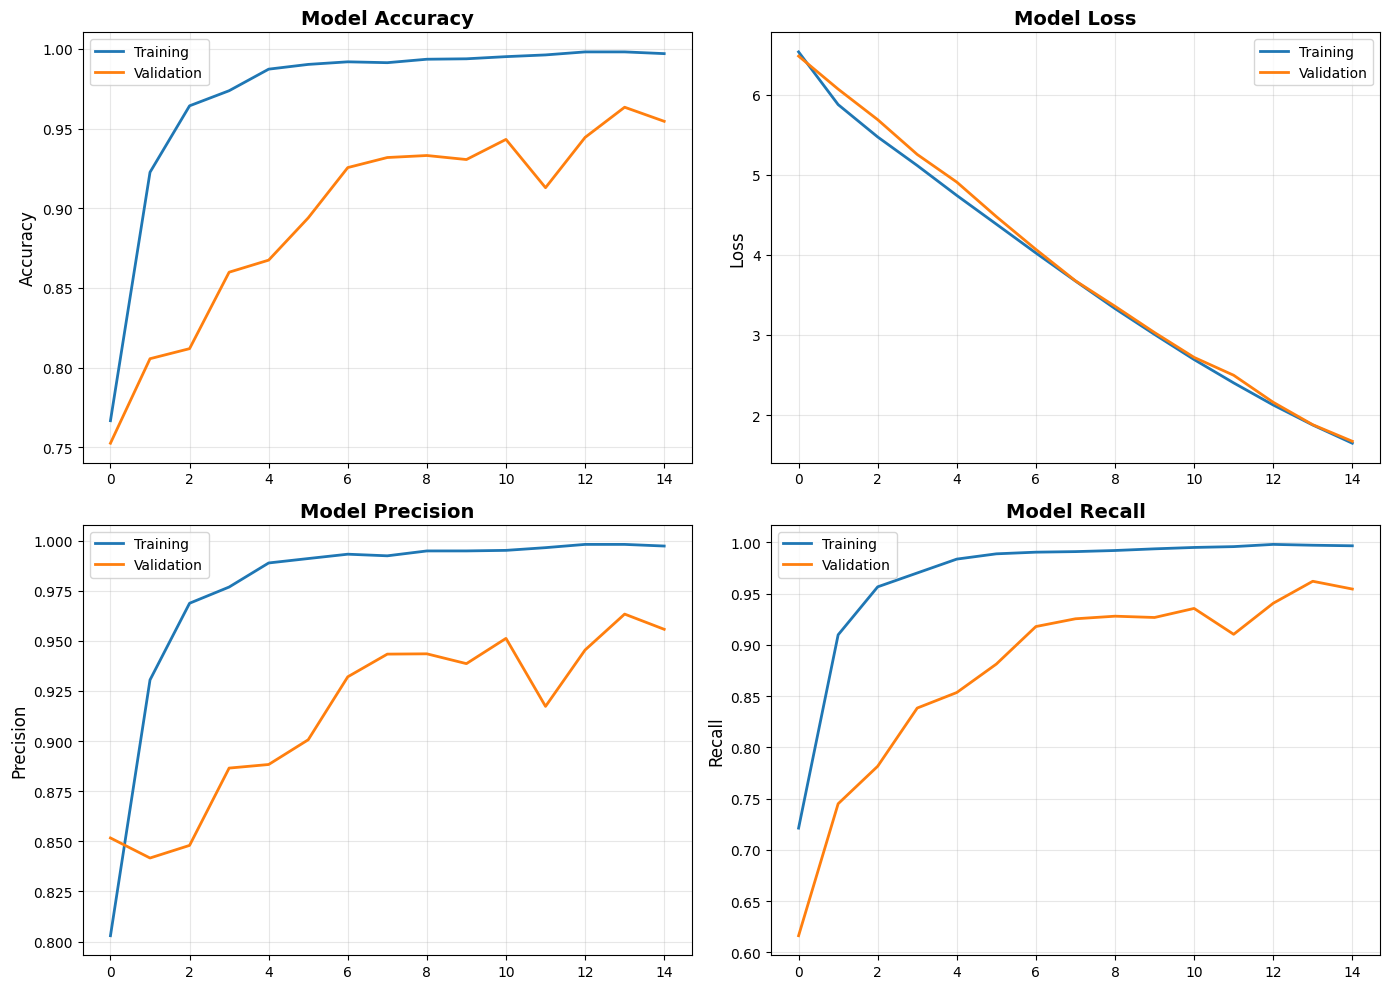

✓ Training history plots saved


In [11]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Training', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Training', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Validation', linewidth=2)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Training', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Validation', linewidth=2)
axes[1, 1].set_ylabel('Recall', fontsize=12)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(LOGS_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history plots saved")


## 6. Evaluate Model Performance on Test Set

In [12]:
# Evaluate on test set
print("Evaluating on test set...")
loss, accuracy, precision, recall = model.evaluate(X_test_norm, y_test_encoded, verbose=0)

# Get predictions
y_pred_proba = model.predict(X_test_norm, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Compute metrics
f1 = f1_score(y_true, y_pred, average='weighted')
precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)

# ROC-AUC
try:
    roc_auc = roc_auc_score(y_test_encoded, y_pred_proba, average='weighted', multi_class='ovr')
except:
    roc_auc = 0.0

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)

print("=" * 70)
print("TEST SET EVALUATION METRICS")
print("=" * 70)
print(f"Loss:                    {loss:.4f}")
print(f"Accuracy:                {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision (weighted):    {precision_weighted:.4f}")
print(f"Recall (weighted):       {recall_weighted:.4f}")
print(f"F1 Score (weighted):     {f1:.4f}")
print(f"ROC-AUC (weighted):      {roc_auc:.4f}")
print("=" * 70)


Evaluating on test set...
TEST SET EVALUATION METRICS
Loss:                    1.6358
Accuracy:                0.9621 (96.21%)
Precision (weighted):    0.9635
Recall (weighted):       0.9621
F1 Score (weighted):     0.9621
ROC-AUC (weighted):      0.9984



Detailed Classification Report:
              precision    recall  f1-score   support

      Glioma       0.90      0.98      0.94       183
  Meningioma       0.96      0.90      0.93       184
   Pituitary       0.99      0.97      0.98       194
    No_Tumor       0.99      0.99      0.99       231

    accuracy                           0.96       792
   macro avg       0.96      0.96      0.96       792
weighted avg       0.96      0.96      0.96       792



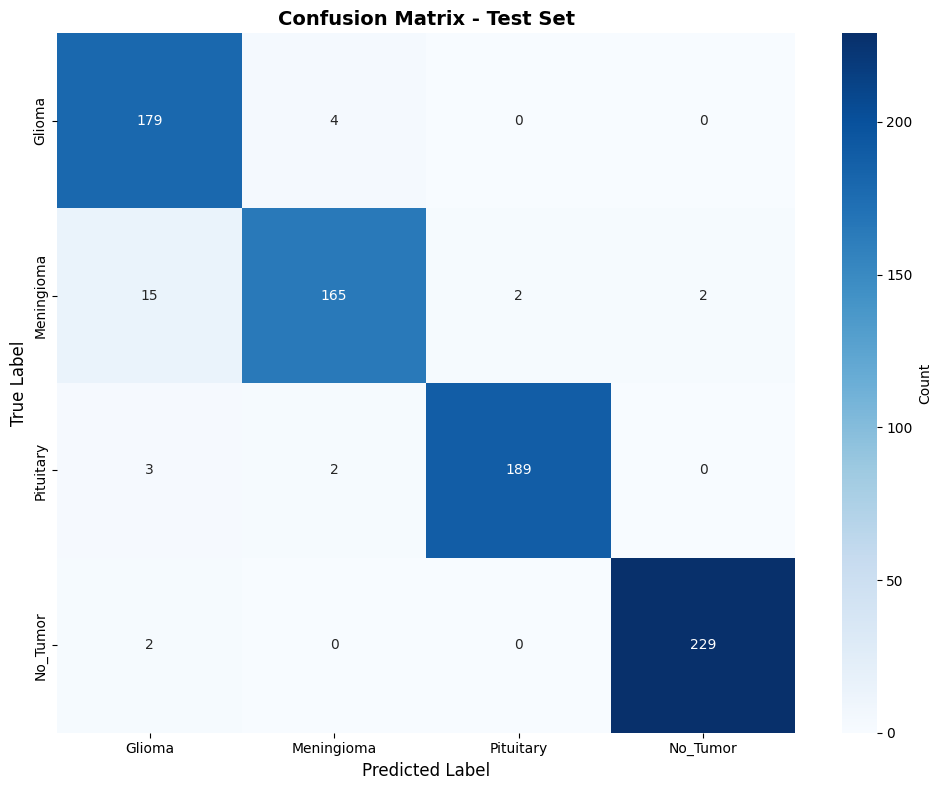

✓ Confusion matrix saved


In [13]:
# Detailed classification report
print("\nDetailed Classification Report:")
print("=" * 70)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    cbar_kws={'label': 'Count'},
    ax=ax
)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(LOGS_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved")


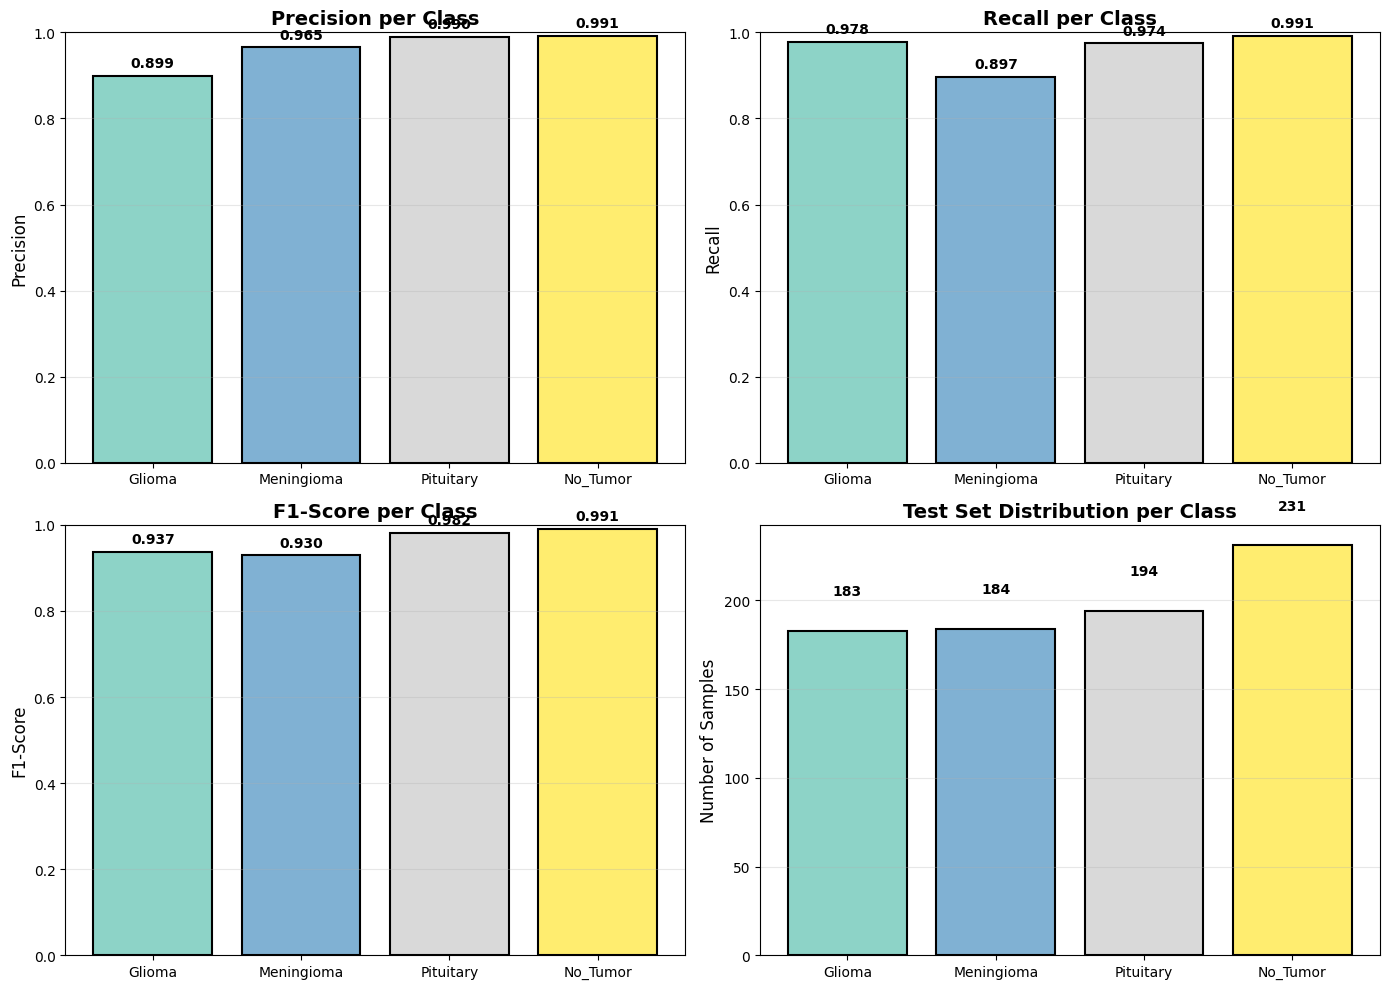

✓ Per-class metrics visualization saved


In [14]:
# Per-class metrics visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Extract per-class metrics
class_names_short = [n.split('(')[0].strip() for n in CLASS_NAMES]
precision_per_class = [class_report[cn]['precision'] for cn in CLASS_NAMES]
recall_per_class = [class_report[cn]['recall'] for cn in CLASS_NAMES]
f1_per_class = [class_report[cn]['f1-score'] for cn in CLASS_NAMES]
support_per_class = [class_report[cn]['support'] for cn in CLASS_NAMES]

# Precision
axes[0, 0].bar(class_names_short, precision_per_class, color=colors, edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('Precision', fontsize=12)
axes[0, 0].set_title('Precision per Class', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(precision_per_class):
    axes[0, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Recall
axes[0, 1].bar(class_names_short, recall_per_class, color=colors, edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('Recall', fontsize=12)
axes[0, 1].set_title('Recall per Class', fontsize=14, fontweight='bold')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(recall_per_class):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# F1-Score
axes[1, 0].bar(class_names_short, f1_per_class, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('F1-Score', fontsize=12)
axes[1, 0].set_title('F1-Score per Class', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1_per_class):
    axes[1, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Support
axes[1, 1].bar(class_names_short, support_per_class, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('Number of Samples', fontsize=12)
axes[1, 1].set_title('Test Set Distribution per Class', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(support_per_class):
    axes[1, 1].text(i, v + 20, str(int(v)), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(LOGS_DIR / 'per_class_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Per-class metrics visualization saved")


## 7. Model Interpretability - Grad-CAM

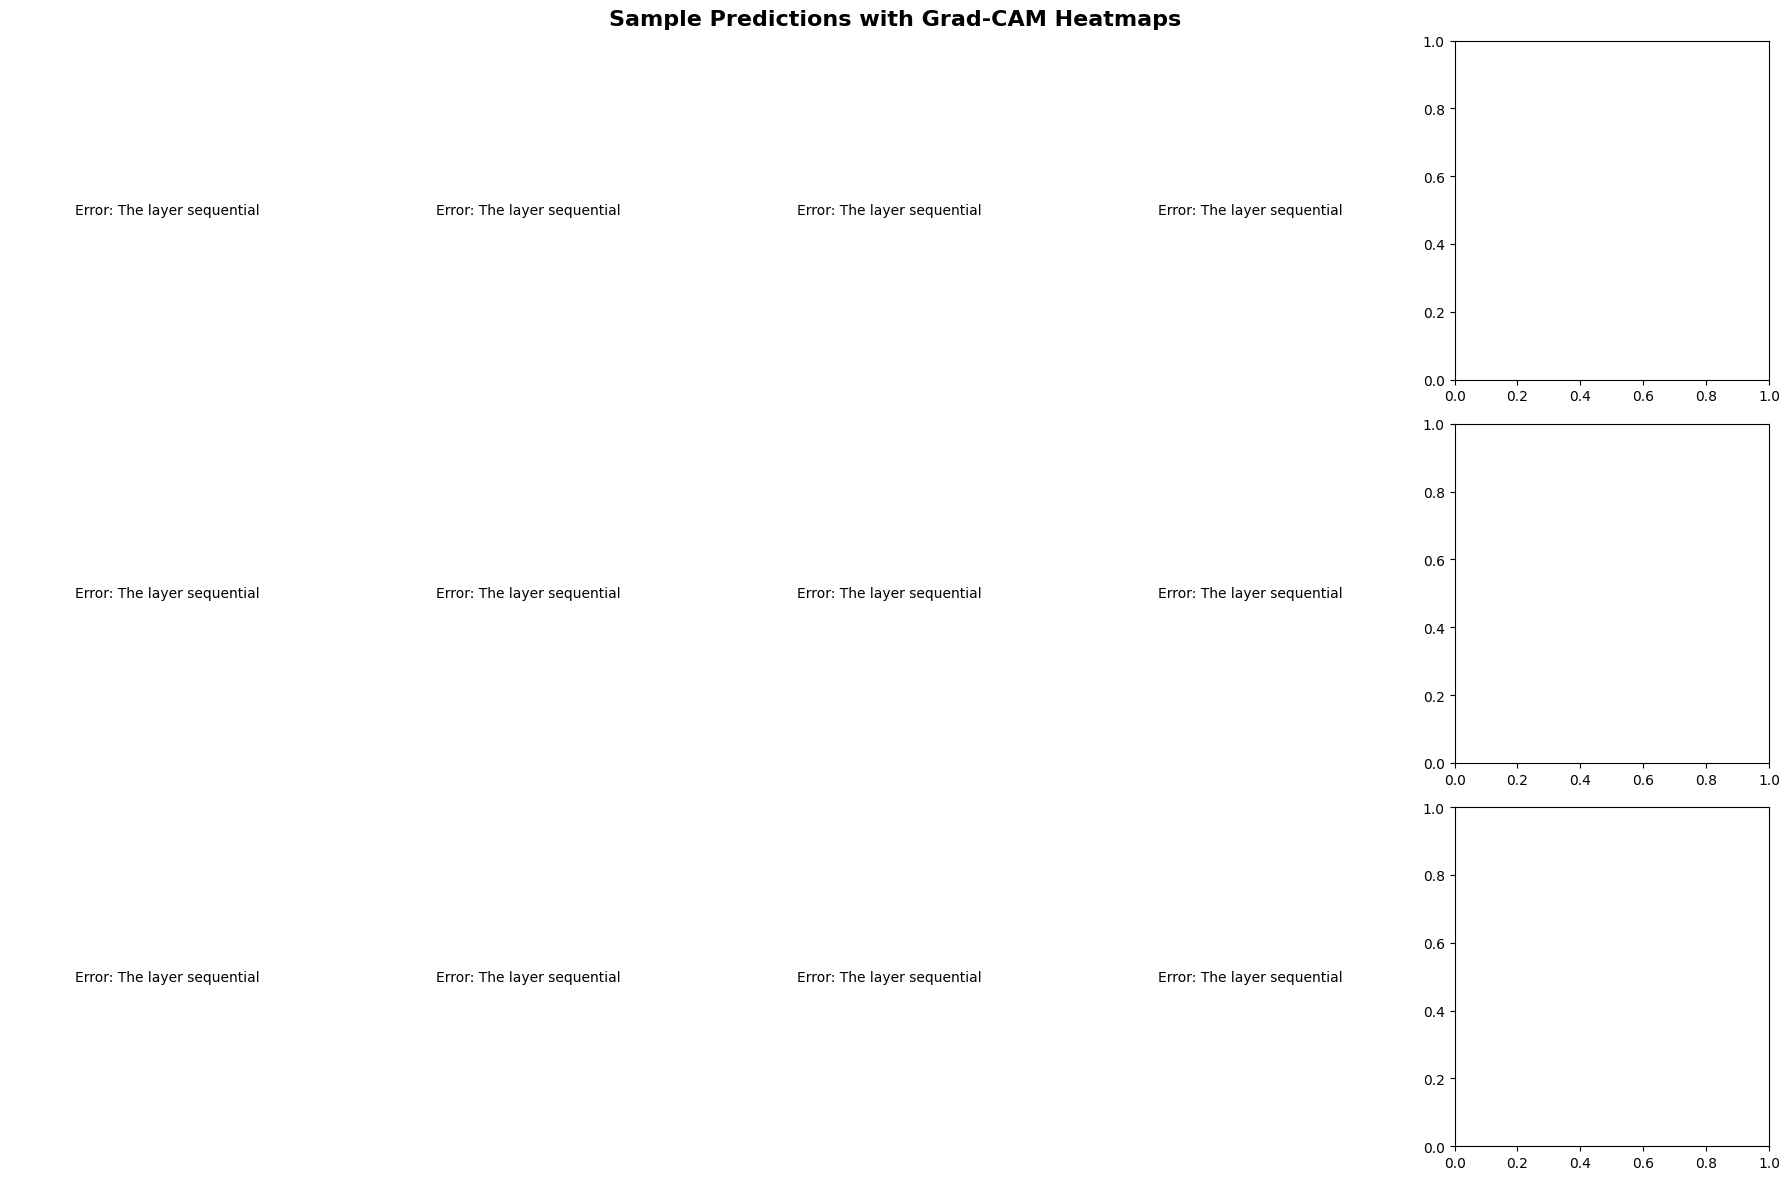

✓ Grad-CAM visualizations created


In [15]:
# Define ImageNet normalization constants
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

# Grad-CAM implementation for interpretability
def get_grad_cam(model, image_array, class_idx):
    """
    Generate Grad-CAM heatmap for model interpretability.
    """
    # Create a model that outputs both the predictions and the last conv layer output
    # Get the last convolutional layer (MobileNetV2's output)
    last_conv_layer = model.layers[0]  # MobileNetV2 is the first layer (base_model)
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [last_conv_layer.output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_array)
        loss = predictions[:, class_idx]
    
    # Compute gradients
    output_channels = conv_outputs.shape[-1]
    grads = tape.gradient(loss, conv_outputs)
    
    # Average the gradients over spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply by conv layer outputs and sum
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    
    # Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Display sample predictions with Grad-CAM
fig, axes = plt.subplots(3, 5, figsize=(18, 12))
fig.suptitle('Sample Predictions with Grad-CAM Heatmaps', fontsize=16, fontweight='bold')

for row in range(3):
    # Select one sample from each class
    for col in range(NUM_CLASSES):
        class_indices = np.where(y_test == col)[0]
        if len(class_indices) > 0:
            sample_idx = class_indices[row % len(class_indices)]
            
            # Get image and prediction
            img = X_test_norm[sample_idx]
            pred_proba = y_pred_proba[sample_idx]
            pred_class = np.argmax(pred_proba)
            confidence = pred_proba[pred_class]
            
            # Reshape for model
            img_batch = np.expand_dims(img, axis=0)
            
            # Get Grad-CAM
            try:
                heatmap = get_grad_cam(model, img_batch, pred_class)
                
                # Resize heatmap to image size
                heatmap_resized = tf.image.resize(
                    np.expand_dims(np.expand_dims(heatmap, 0), -1),
                    (IMAGE_SIZE[0], IMAGE_SIZE[1])
                )[0, :, :, 0].numpy()
                
                # Denormalize image for display
                img_denorm = img.copy()
                for i in range(3):
                    img_denorm[:, :, i] = img_denorm[:, :, i] * IMAGENET_STD[i] + IMAGENET_MEAN[i]
                img_denorm = np.clip(img_denorm, 0, 1)
                
                # Plot
                ax = axes[row, col]
                ax.imshow(img_denorm)
                ax.imshow(heatmap_resized, cmap='jet', alpha=0.4)
                
                true_class = CLASS_NAMES[y_test[sample_idx]]
                pred_class_name = CLASS_NAMES[pred_class]
                title = f"Pred: {pred_class_name}\n({confidence:.2%})\nTrue: {true_class}"
                ax.set_title(title, fontsize=10, fontweight='bold')
                ax.axis('off')
            except Exception as e:
                ax = axes[row, col]
                ax.text(0.5, 0.5, f'Error: {str(e)[:20]}', ha='center', va='center')
                ax.axis('off')

plt.tight_layout()
plt.savefig(LOGS_DIR / 'gradcam_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Grad-CAM visualizations created")

## 8. Save Model and Metadata

In [16]:
# Save the final model
model_path = MODELS_DIR / 'brain_tumor_model_v1.h5'
model.save(str(model_path))
print(f"✓ Model saved to {model_path}")

# Save model metadata
metadata = {
    'model_name': 'Brain Tumor MRI Classifier',
    'version': '1.0',
    'architecture': 'MobileNetV2 Transfer Learning',
    'input_shape': tuple(s if s is not None else -1 for s in model.input_shape),
    'num_classes': NUM_CLASSES,
    'class_labels': CLASS_NAMES,
    'training_date': datetime.now().isoformat(),
    'metrics': {
        'accuracy': float(accuracy),
        'loss': float(loss),
        'precision': float(precision_weighted),
        'recall': float(recall_weighted),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc)
    },
    'hyperparameters': {
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'epochs_trained': len(history.history['loss']),
        'optimizer': 'Adam'
    }
}

metadata_path = MODELS_DIR / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata saved to {metadata_path}")

# Save training history
history_path = LOGS_DIR / 'training_history.json'
history_dict = {k: [float(v) for v in vals] for k, vals in history.history.items()}
with open(history_path, 'w') as f:
    json.dump(history_dict, f, indent=2)
print(f"✓ Training history saved to {history_path}")

print("\n" + "="*70)
print("TRAINING & EVALUATION COMPLETE")
print("="*70)
print(f"Model saved:     {model_path}")
print(f"Metadata saved:  {metadata_path}")
print(f"History saved:   {history_path}")
print(f"Logs directory:  {LOGS_DIR}")
print("="*70)

2025-11-21 21:38:03,868 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


✓ Model saved to /Users/apple/MLOP/models/brain_tumor_model_v1.h5
✓ Metadata saved to /Users/apple/MLOP/models/model_metadata.json
✓ Training history saved to /Users/apple/MLOP/logs/training_history.json

TRAINING & EVALUATION COMPLETE
Model saved:     /Users/apple/MLOP/models/brain_tumor_model_v1.h5
Metadata saved:  /Users/apple/MLOP/models/model_metadata.json
History saved:   /Users/apple/MLOP/logs/training_history.json
Logs directory:  /Users/apple/MLOP/logs


## 9. Make Predictions on New Images

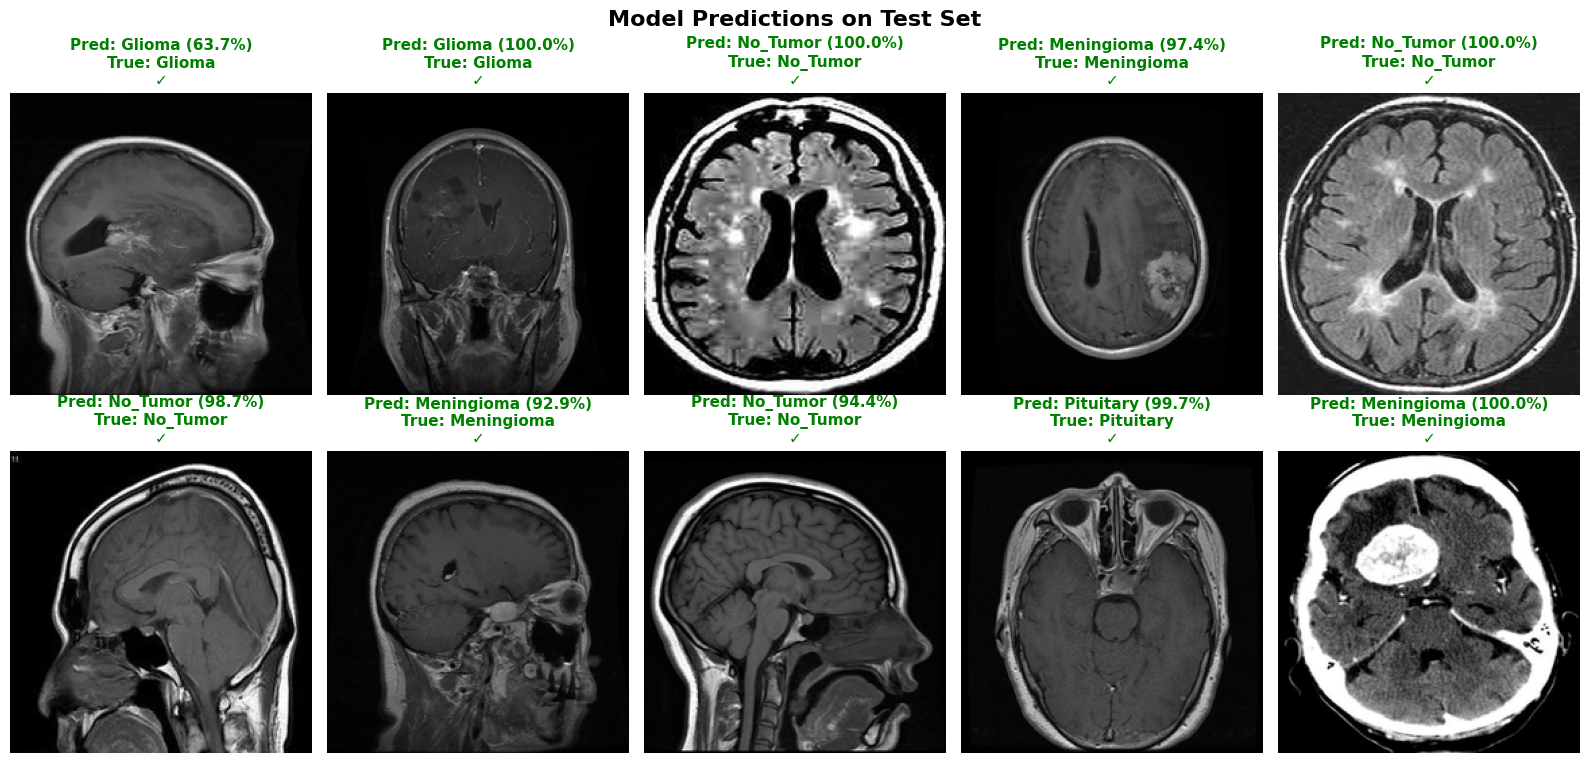

✓ Predictions visualized and saved


In [17]:
# Test prediction on random test samples
def predict_and_visualize(model, images, labels, num_samples=10):
    """Make predictions and visualize results."""
    
    # Select random samples
    indices = np.random.choice(len(images), size=min(num_samples, len(images)), replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(16, 8))
    fig.suptitle('Model Predictions on Test Set', fontsize=16, fontweight='bold')
    axes = axes.flatten()
    
    for idx, sample_idx in enumerate(indices):
        # Denormalize image
        img = images[sample_idx].copy()
        for i in range(3):
            img[:, :, i] = img[:, :, i] * IMAGENET_STD[i] + IMAGENET_MEAN[i]
        img = np.clip(img, 0, 1)
        
        # Get prediction
        img_batch = np.expand_dims(images[sample_idx], axis=0)
        pred_proba = model.predict(img_batch, verbose=0)[0]
        pred_class = np.argmax(pred_proba)
        confidence = pred_proba[pred_class]
        
        # Display
        ax = axes[idx]
        ax.imshow(img)
        
        true_class = CLASS_NAMES[labels[sample_idx]]
        pred_class_name = CLASS_NAMES[pred_class]
        is_correct = true_class == pred_class_name
        
        title = f"Pred: {pred_class_name} ({confidence:.1%})\nTrue: {true_class}\n{'✓' if is_correct else '✗'}"
        ax.set_title(title, fontsize=11, fontweight='bold', 
                    color='green' if is_correct else 'red')
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(LOGS_DIR / 'predictions_sample.png', dpi=150, bbox_inches='tight')
    plt.show()

predict_and_visualize(model, X_test_norm, y_test, num_samples=10)
print("✓ Predictions visualized and saved")


In [18]:
# Summary of model performance
print("\n" + "="*70)
print("MODEL PERFORMANCE SUMMARY")
print("="*70)
print(f"\n📊 Overall Metrics:")
print(f"   • Accuracy:           {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   • Precision (weighted): {precision_weighted:.4f}")
print(f"   • Recall (weighted):    {recall_weighted:.4f}")
print(f"   • F1-Score (weighted):  {f1:.4f}")
print(f"   • ROC-AUC (weighted):   {roc_auc:.4f}")

print(f"\n📈 Per-Class Performance:")
for i, class_name in enumerate(CLASS_NAMES):
    print(f"   {class_name}:")
    print(f"      Precision: {class_report[class_name]['precision']:.4f}, Recall: {class_report[class_name]['recall']:.4f}, F1: {class_report[class_name]['f1-score']:.4f}")

print(f"\n💾 Artifacts Saved:")
print(f"   • Model:       {MODELS_DIR / 'brain_tumor_model_v1.h5'}")
print(f"   • Metadata:    {MODELS_DIR / 'model_metadata.json'}")
print(f"   • History:     {LOGS_DIR / 'training_history.json'}")
print(f"   • Logs:        {LOGS_DIR}/")

print(f"\n🎯 Ready for Deployment!")
print("="*70)


MODEL PERFORMANCE SUMMARY

📊 Overall Metrics:
   • Accuracy:           0.9621 (96.21%)
   • Precision (weighted): 0.9635
   • Recall (weighted):    0.9621
   • F1-Score (weighted):  0.9621
   • ROC-AUC (weighted):   0.9984

📈 Per-Class Performance:
   Glioma:
      Precision: 0.8995, Recall: 0.9781, F1: 0.9372
   Meningioma:
      Precision: 0.9649, Recall: 0.8967, F1: 0.9296
   Pituitary:
      Precision: 0.9895, Recall: 0.9742, F1: 0.9818
   No_Tumor:
      Precision: 0.9913, Recall: 0.9913, F1: 0.9913

💾 Artifacts Saved:
   • Model:       /Users/apple/MLOP/models/brain_tumor_model_v1.h5
   • Metadata:    /Users/apple/MLOP/models/model_metadata.json
   • History:     /Users/apple/MLOP/logs/training_history.json
   • Logs:        /Users/apple/MLOP/logs/

🎯 Ready for Deployment!
